## 了解算法性能中的偏差和方差概念
+ 案例：利用水库水位变化预测大坝出水量
+ 数据集：ex5data1.mat

![image.png](<https://i.typlog.com/tanxy/8336422276_571583.png>)
![image.png](<https://i.typlog.com/tanxy/8336422177_1643095.png>)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

In [48]:
data = loadmat('ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [49]:
# 训练集
X_train, y_train = data['X'], data['y']
X_train.shape, y_train.shape

((12, 1), (12, 1))

In [50]:
# 验证集
X_val, y_val = data['Xval'], data['yval']
X_val.shape, y_val.shape

((21, 1), (21, 1))

In [51]:
# 测试集
X_test, y_test = data['Xtest'], data['ytest']
X_test.shape, y_test.shape

((21, 1), (21, 1))

In [52]:
# 添加常数列
X_train = np.insert(X_train,0,1,axis=1)
X_val  = np.insert(X_val,0,1,axis=1)
X_test = np.insert(X_test,0,1,axis=1)
# X_train.shape, X_val.shape, X_test.shape, 
X_train

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

In [53]:
# 对训练集的数据做一个线性回归看看效果
def plot_data():
    fig,ax = plt.subplots()
    ax.scatter(X_train[:,1],y_train)
    ax.set(xlabel='change in water level(x)', ylabel='water flowing out og the dam(y)')

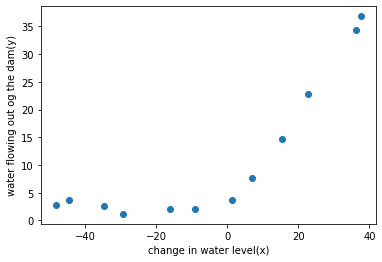

In [54]:
plot_data()

In [55]:
def reg_cost(theta,X,y,lamda):
    
    cost = np.sum(np.power((X@theta - y.flatten()),2)) # 为什么要 flatten() 因为 theta 是一维数组，而 X @ theta-y ...
    
    reg = theta[1:]@theta[1:]*lamda
    
    return (cost + reg) / (2 * len(X))

In [59]:
theta = np.ones(X_train.shape[1])
lamda = 1
reg_cost(theta,X_train,y_train,lamda)

303.9931922202643

In [60]:
def reg_gradient(theta,X,y,lamda):
    
    grad = (X@theta-y.flatten())@X
    reg = lamda * theta
    reg[0] = 0
    
    return (grad+reg) / len(X)

In [61]:
reg_gradient(theta,X_train,y_train,lamda)

array([-15.30301567, 598.25074417])

In [65]:
def train_model(X,y,lamda):
    
    theta = np.ones(X.shape[1])
    
    res = minimize(fun=reg_cost,
                  x0=theta,
                  args=(X,y,lamda),
                  method='TNC',
                  jac=reg_gradient)
    
    return res.x # 返回优化好的 theta 值

In [66]:
theta_final = train_model(X_train,y_train,lamda=0)

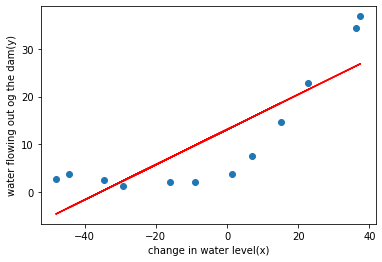

In [69]:
plot_data()
plt.plot(X_train[:,1],X_train@theta_final,c='r')
plt.show() # 可以看出现在处于欠拟合状态，目前偏差非常大

## 任务：从训练样本从 1 开始递增进行训练，比较训练集和验证集上的损失函数的变化情况

In [109]:
def plot_learning_curve(X_train,y_train,X_val,y_val,lamda):
    
    x = range(1, len(X_train)+1) # + 1 是因为 range 取不到最后一个
    training_cost = []
    cv_cost = []
    
    for i in x:
        res = train_model(X_train[:i,:],y_train[:i,:],lamda)
        training_cost_i = reg_cost(res,X_train[:i,:],y_train[:i,:],lamda)
        cv_cost_i = reg_cost(res,X_val,y_val,lamda)
        training_cost.append(training_cost_i)
        cv_cost.append(cv_cost_i)
        
    plt.plot(x,training_cost,label='training cost')
    plt.plot(x,cv_cost,label='cv cost')
    plt.legend()
    plt.xlabel('number of training examples')
    plt.ylabel('error')
    plt.show()

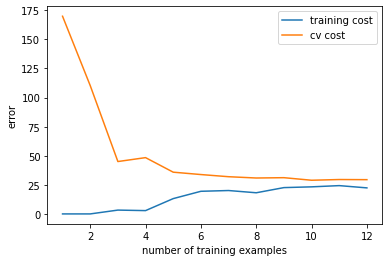

In [110]:
plot_learning_curve(X_train,y_train,X_val,y_val,lamda=0)
# 随着样本增加，训练集损失函数的变化以及验证集的变化
# 可以看出样本比较少的时候，训练误差比较小，但是验证集误差比较大，因为还没从样本学出什么东西来
# 但是随着样本个数增多，验证集误差下降
# 可以从下图看出随着样本增多，最终训练集和验证集的误差还是比较大，因为这是一个高偏差的模型
# 即该模型欠拟合

简单的线性模型造成了欠拟合

![image.png](<https://i.typlog.com/tanxy/8336418788_112964.png>)

## 任务：构造多项式特征，进行多项式回归

In [111]:
def poly_feature(X,power):
    
    for i in range(2, power+1):
        X = np.insert(X,X.shape[1],np.power(X[:,1],i),axis=1)
    return X

In [112]:
def get_means_stds(X):
    
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    return means, stds

In [113]:
# 特征归一化
def feature_normalize(X,means,stds):
    X[:,1:] = (X[:,1:] - means[1:]) / stds[1:]
    
    return X

In [114]:
power = 6

In [115]:
X_train_poly = poly_feature(X_train,power)
X_val_poly = poly_feature(X_val,power)
X_test_poly = poly_feature(X_test,power)

In [116]:
train_means, train_stds = get_means_stds(X_train_poly)

In [117]:
X_train_norm = feature_normalize(X_train_poly,train_means,train_stds)
X_val_norm = feature_normalize(X_val_poly,train_means,train_stds)
X_test_norm = feature_normalize(X_test_poly,train_means,train_stds)

In [118]:
theta_fit = train_model(X_train_norm,y_train,lamda=0)

In [119]:
def plot_poly_fit():
    plot_data()
    x = np.linspace(-60,60,100)
    xx = x.reshape(100,1)
    xx = np.insert(xx,0,1,axis=1)
    xx = poly_feature(xx,power)
    xx = feature_normalize(xx,train_means,train_stds)
    
    plt.plot(x,xx@theta_fit,'r--')

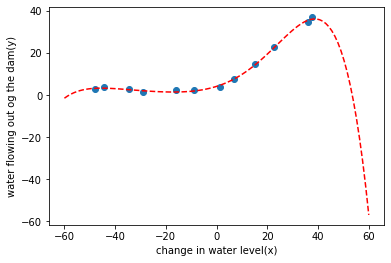

In [120]:
plot_poly_fit()

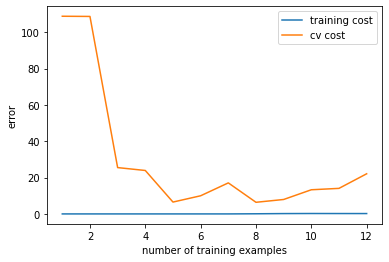

In [122]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=0)

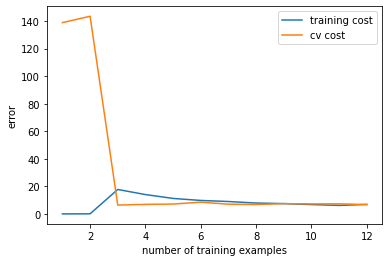

In [123]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=1)

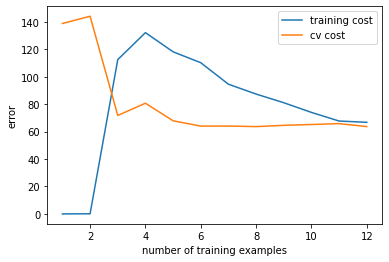

In [124]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=100)

In [125]:
# 一般来说 lamda 过小，模型容易过拟合；lamda 过大，模型容易欠拟合

In [128]:
lamdas = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]
training_cost = []
cv_cost = []

for lamda in lamdas:
    res = train_model(X_train_norm,y_train,lamda)
    
    tc = reg_cost(res,X_train_norm,y_train,lamda=0)
    cv = reg_cost(res,X_val_norm,y_val,lamda=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

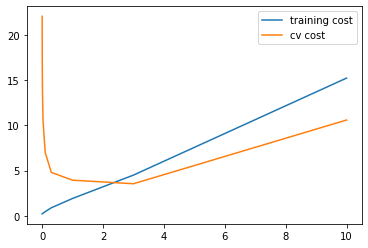

In [130]:
plt.plot(lamdas,training_cost,label='training cost')
plt.plot(lamdas,cv_cost,label='cv cost')
plt.legend()

plt.show()

In [131]:
lamdas[np.argmin(cv_cost)]

3

In [135]:
res = train_model(X_train_norm,y_train,lamda=3)
test_cost = reg_cost(res,X_test_norm,y_test,lamda=0)
print(test_cost) # 测试集上的误差

4.397616167106991
